In [1]:
import json
import pandas as pd


In [2]:
with open('../intents.json') as f:
    data = json.load(f)
data 

{'intents': [{'tag': 'greeting',
   'patterns': ['Hi',
    'Hey',
    'Is anyone there?',
    'Hi there',
    'Hello',
    'Hey there',
    'Howdy',
    'Hola',
    'Bonjour',
    'Konnichiwa',
    'Guten tag',
    'Ola'],
   'responses': ['Hello there. Tell me how are you feeling today?',
    'Hi there. What brings you here today?',
    'Hi there. How are you feeling today?',
    'Great to see you. How do you feel currently?',
    "Hello there. Glad to see you're back. What's going on in your world right now?"]},
  {'tag': 'morning',
   'patterns': ['Good morning'],
   'responses': ["Good morning. I hope you had a good night's sleep. How are you feeling today? "]},
  {'tag': 'afternoon',
   'patterns': ['Good afternoon'],
   'responses': ['Good afternoon. How is your day going?']},
  {'tag': 'evening',
   'patterns': ['Good evening'],
   'responses': ['Good evening. How has your day been?']},
  {'tag': 'night',
   'patterns': ['Good night'],
   'responses': ['Good night. Get some prop

In [3]:
# Flattening the dataset for EDA and modelling
dic = {'tags':[], 'patterns':[], 'responses':[]}

for example in data['intents']:
   
    for pattern in example['patterns']:
        dic['tags'].append(example['tag'])
        dic['patterns'].append(pattern)
        dic['responses'].append(example['responses'])
dic


{'tags': ['greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'greeting',
  'morning',
  'afternoon',
  'evening',
  'night',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'goodbye',
  'thanks',
  'thanks',
  'thanks',
  'thanks',
  'thanks',
  'no-response',
  'neutral-response',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'about',
  'skill',
  'creation',
  'creation',
  'creation',
  'name',
  'name',
  'name',
  'help',
  'help',
  'help',
  'help',
  'help',
  'help',
  'help',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'sad',
  'stressed',
  'stressed',
  'stressed',
  'stressed',
  'stressed',
  'worthless',
  'worthless',
  'worthless',
  'worthless',
  'worthless',
  'depressed',
  'depressed',
  'depressed',
  'depressed',
  'happy',
  'happy',
  'happy',
  'happy',
  'happ

In [4]:
df = pd.DataFrame.from_dict(dic)
df

,tags,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [5]:
df['tags'].value_counts()

tags
greeting    12
casual      11
sad          8
goodbye      8
default      8
            ..
fact-25      1
fact-28      1
fact-29      1
fact-30      1
fact-31      1
Name: count, Length: 80, dtype: int64

In [6]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
import torch
from torch.cuda.amp import autocast  # For mixed precision

# Load the Pegasus model and tokenizer
model_name = "tuner007/pegasus_paraphrase"
model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')
tokenizer = PegasusTokenizer.from_pretrained(model_name)

def paraphrase_with_pegasus(texts, num_return_sequences=5, num_beams=10):
    # Tokenize the input texts and move to GPU
    input_ids = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to('cuda')
    
    # Generate paraphrases on GPU with mixed precision
    with autocast():  # Enable mixed precision
        outputs = model.generate(
            input_ids["input_ids"],
            attention_mask=input_ids["attention_mask"],
            max_length=50,
            num_beams=num_beams,  # Adjust num_beams for better performance
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    
    # Decode all outputs at once and move back to CPU
    paraphrased_texts = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return paraphrased_texts

# Example usage with batch processing
texts = [
    "What does it mean to have a mental illness?",
    "How can I improve my mental health?",
    "What are the symptoms of depression?"
]

paraphrased_texts = paraphrase_with_pegasus(texts, num_return_sequences=4, num_beams=10)
for i, paraphrase in enumerate(paraphrased_texts):
    print(f"Paraphrase {i+1}: {paraphrase}")

f:\Anaconda_Navigator\envs\hf_transformers_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\seleem\AppData\Local\Temp\ipykernel_13740\2869978348.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # Enable mixed precision


Paraphrase 1: What does a mental illness mean?
Paraphrase 2: What do you mean by a mental illness?
Paraphrase 3: What does mental illness mean?
Paraphrase 4: What does a mental illness mean to you?
Paraphrase 5: How can I improve my mental health?
Paraphrase 6: How can I improve my health?
Paraphrase 7: Can I improve my mental health?
Paraphrase 8: How do I improve my mental health?
Paraphrase 9: What are the symptoms of depression?
Paraphrase 10: What are the signs of depression?
Paraphrase 11: There are some symptoms of depression.
Paraphrase 12: What are some symptoms of depression?


In [7]:
df

,tags,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


In [8]:
df['tags']

0      greeting
1      greeting
2      greeting
3      greeting
4      greeting
         ...   
227     fact-29
228     fact-30
229     fact-31
230     fact-32
231     fact-32
Name: tags, Length: 232, dtype: object

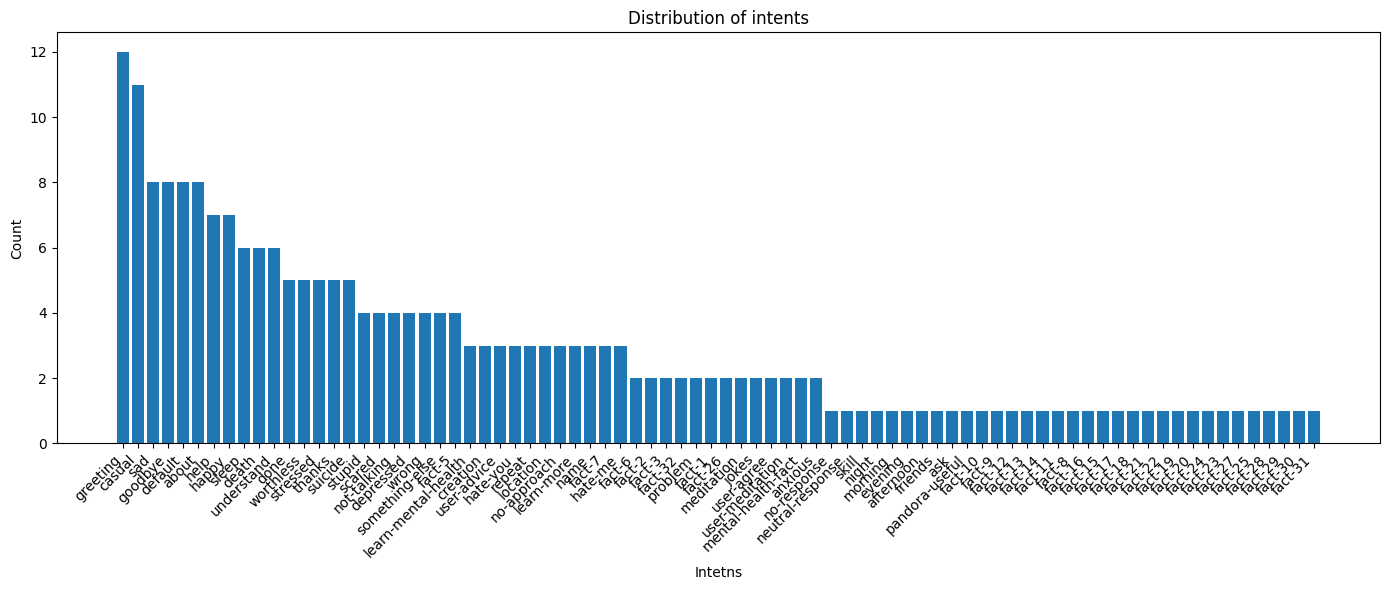

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))

plt.bar(df['tags'].value_counts().index,df['tags'].value_counts().values)

plt.title('Distribution of intents')
plt.xlabel('Intetns')
plt.ylabel('Count')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

In [10]:
from torch.utils.data import Dataset  , DataLoader

class PatternDataset(Dataset):
    def __init__(self,patterns):
    
      self.patterns = patterns
    
    def __len__(self):

      return len(self.patterns)
    
    def __getitem__ (self,idx):
      
      return self.patterns[idx]


In [17]:
from transformers import PegasusForConditionalGeneration, PegasusTokenizer
from torch.cuda.amp import autocast
import torch
from multiprocessing import Pool, cpu_count

model_name = "tuner007/pegasus_paraphrase"
model = PegasusForConditionalGeneration.from_pretrained(model_name).to('cuda')
tokenizer = PegasusTokenizer.from_pretrained(model_name)

def paraphrase_with_pegasus(texts, num_return_sequences=2, num_beams=10):
    input_ids = tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to("cuda")
    
    with autocast():
        outputs = model.generate(
            input_ids["input_ids"],
            attention_mask=input_ids["attention_mask"],
            max_length=80,
            num_beams=num_beams,
            num_return_sequences=num_return_sequences,
            no_repeat_ngram_size=2,
            early_stopping=True
        )
    
    return tokenizer.batch_decode(outputs, skip_special_tokens=True)

import logging
logging.basicConfig(level=logging.INFO)  # Enable logging

# def augment_patterns(tags_patterns, target_count=12, batch_size=64, num_workers=None):
#     if num_workers is None:
#         num_workers = max(1, cpu_count() - 1)

#     augmented_patterns = {}
    
#     for tag, patterns in tags_patterns.items():
#         logging.info(f"Starting augmentation for tag: {tag}")  # Log the start of processing for a tag
        
#         unique_patterns = set(patterns)  # Use a set to track unique patterns
#         needed = target_count - len(unique_patterns)

#         if needed > 0:
#             dataset = PatternDataset(list(unique_patterns))
#             dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
            
#             max_attempts = 1000  # To avoid infinite loops
#             attempts = 0

#             with Pool(num_workers) as pool:
#                 while len(unique_patterns) < target_count:
#                     for batch in dataloader:
#                         paraphrased = paraphrase_with_pegasus(batch)
#                         unique_patterns.update(paraphrased)

#                         logging.info(
#                             f"Tag: {tag} | Generated {len(paraphrased)} new patterns | "
#                             f"Total unique patterns: {len(unique_patterns)}/{target_count}"
#                         )

#                         attempts += 1
#                         if len(unique_patterns) >= target_count or attempts >= max_attempts:
#                             break

#                     if attempts >= max_attempts:
#                         logging.warning(
#                             f"Tag: {tag} | Stopped after {attempts} attempts. "
#                             f"Generated {len(unique_patterns)}/{target_count} patterns."
#                         )
#                         break

#         augmented_patterns[tag] = list(unique_patterns)

#         logging.info(f"Completed augmentation for tag: {tag} | Total patterns: {len(unique_patterns)}")

#     return augmented_patterns




Some weights of PegasusForConditionalGeneration were not initialized from the model checkpoint at tuner007/pegasus_paraphrase and are newly initialized: ['model.decoder.embed_positions.weight', 'model.encoder.embed_positions.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
def augment_patterns(tags_patterns, target_count=12, batch_size=64, num_workers=None):
    if num_workers is None:
        num_workers = max(1, cpu_count() - 1)

    augmented_patterns = {}
    
    for tag, patterns in tags_patterns.items():
        logging.info(f"Starting augmentation for tag: {tag}")  # Log start
        
        # Initialize unique patterns and a queue for processing
        unique_patterns = set(patterns)
        pattern_queue = list(unique_patterns)  # Use a queue to process patterns

        while len(unique_patterns) < target_count and pattern_queue:
            current_batch = pattern_queue[:batch_size]
            pattern_queue = pattern_queue[batch_size:]  # Remove processed batch
            
            # Generate paraphrases for the current batch
            paraphrased = paraphrase_with_pegasus(current_batch)
            
            # Normalize patterns to avoid duplicates due to formatting
            paraphrased = [pattern.strip().lower() for pattern in paraphrased]
            
            # Add new patterns to unique_patterns and reprocess them
            for pattern in paraphrased:
                if pattern not in unique_patterns:
                    unique_patterns.add(pattern)
                    pattern_queue.append(pattern)  # Add new pattern back to the queue
            
            # Log progress
            logging.info(
                f"Tag: {tag} | Generated {len(paraphrased)} new patterns | "
                f"Total unique patterns: {len(unique_patterns)}/{target_count}"
            )

            # Break if we reach the target count
            if len(unique_patterns) >= target_count:
                break

        augmented_patterns[tag] = list(unique_patterns)
        logging.info(f"Completed augmentation for tag: {tag} | Total patterns: {len(unique_patterns)}")

    return augmented_patterns


In [21]:
tags_patterns = {}

for tag, pattern in zip(dic['tags'],dic['patterns']):
    tags_patterns.setdefault(tag,[]).append(pattern)

augmented_patterns = augment_patterns(tags_patterns)

with open('pegasus_data.josn','w')as f:
    json.dump(augmented_patterns, f, indent=4)
    
augmented_patterns

INFO:root:Starting augmentation for tag: greeting
INFO:root:Completed augmentation for tag: greeting | Total patterns: 12
INFO:root:Starting augmentation for tag: morning
C:\Users\seleem\AppData\Local\Temp\ipykernel_13740\1767127280.py:13: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
INFO:root:Tag: morning | Generated 2 new patterns | Total unique patterns: 3/12
INFO:root:Tag: morning | Generated 4 new patterns | Total unique patterns: 4/12
INFO:root:Tag: morning | Generated 2 new patterns | Total unique patterns: 6/12
INFO:root:Tag: morning | Generated 4 new patterns | Total unique patterns: 7/12
INFO:root:Tag: morning | Generated 2 new patterns | Total unique patterns: 8/12
INFO:root:Tag: morning | Generated 2 new patterns | Total unique patterns: 8/12
INFO:root:Completed augmentation for tag: morning | Total patterns: 8
INFO:root:Starting augmentation for tag: afternoon
INFO:root:Tag: af

{'greeting': ['Guten tag',
  'Hey',
  'Hello',
  'Bonjour',
  'Hola',
  'Konnichiwa',
  'Is anyone there?',
  'Howdy',
  'Hi there',
  'Hey there',
  'Hi',
  'Ola'],
 'morning': ['it is a good morning.',
  'it is a nice day.',
  'it is a nice morning.',
  'good morning.',
  'good morning!',
  'it is pleasant.',
  'it is nice.',
  'Good morning'],
 'afternoon': ['it is a good morning.',
  'it is a nice day.',
  'good day.',
  'it is a nice morning.',
  'Good afternoon',
  'good morning.',
  'it is nice.',
  'it is pleasant.'],
 'evening': ['good night.',
  'good evening.',
  'it was a good night.',
  'it was pleasant.',
  'it was a nice evening.',
  'it was a wonderful night.',
  'it was nice.',
  'Good evening',
  'it was a good evening.',
  'it was a great night.'],
 'night': ['it was a good night.',
  'good night!',
  'Good night',
  'it was a wonderful night.',
  'good night.',
  'it was a great night.'],
 'goodbye': ['alright bye.',
  'Fare thee well',
  'well done.',
  'bye.',
  '